# Example of creating a remapping file based on inverse distance with various powers for WRF dataset

In [1]:
import pandas as pd
import numpy as np
from easymore import Easymore
import matplotlib.pyplot as plt


In [3]:
#
min_lat = 48.0
max_lat = 52.0
max_lon = -110.0
min_lon = -117.0
n_number = 1000

# 
point_df_target = pd.DataFrame()
point_df_target ['lat_t'] = np.random.uniform(low=min_lat, high=max_lat, size=(n_number,))
point_df_target ['lon_t'] = np.random.uniform(low=min_lon, high=max_lon, size=(n_number,))
point_df_target ['ID_t'] = np.arange(n_number)+1

#
esmr = Easymore()
point_target = esmr.make_shape_point(point_df_target, lon_column = 'lon_t' , lat_column = 'lat_t', crs = 'epsg:4326')


EASYMORE version 2.0.0 is initiated.
crs  epsg:4326  is assigned to the point shapefile


In [4]:
#

esmr = Easymore()

# specifying EASYMORE objects
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
esmr.temp_dir                 = './temporary/'
esmr.source_nc                = './data/Source_nc_WRF/WRF*.nc'
# name of variables from source netCDF file(s) to be remapped
esmr.var_names                = ['T2']
# name of variable longitude in source netCDF files
esmr.var_lon                  = 'XLONG'
# name of variable latitude in source netCDF files
esmr.var_lat                  = 'XLAT'
# name of variable time in source netCDF file; should be always time
esmr.var_time                 = 'time'
# location where the remapped netCDF file will be saved
esmr.output_dir               = './output/'

esmr.NetCDF_SHP_lat_lon()

wrf_lat = esmr.lat
wrf_lon = esmr.lon
case_type = esmr.case

point_df_source = pd.DataFrame()
point_df_source ['lat_s'] = wrf_lat.flatten()
point_df_source ['lon_s'] = wrf_lon.flatten()
point_df_source ['ID_s'] = np.arange(len(point_df_source))+1

point_source = esmr.make_shape_point(point_df_source, lon_column = 'lon_s' , lat_column = 'lat_s', crs = 'epsg:4326')


EASYMORE version 2.0.0 is initiated.
./data/Source_nc_WRF/WRF*.nc
<class 'str'>
EASYMORE detects case 2 - rotated lat/lon
crs  epsg:4326  is assigned to the point shapefile


In [6]:
import warnings
warnings.simplefilter('ignore')

# loop over the random point and find the weigth to for each point based on inverse distance to wrf grid location

point_target = point_target.to_crs("EPSG:6933")
point_target ['lat_t_m'] = point_target.centroid.y
point_target ['lon_t_m'] = point_target.centroid.x

point_source = point_source.to_crs("EPSG:6933")
point_source ['lat_s_m'] = point_source.centroid.y
point_source ['lon_s_m'] = point_source.centroid.x

powers = [0.5,1,2,3,4]

for power in powers:
    remapping_df = pd.DataFrame()
    for index, row in point_target.iterrows():
        # get the distance
        point_source['distance'] = ((row.lat_t_m-point_source['lat_s_m'])**2+\
                                   (row.lon_t_m-point_source['lon_s_m'])**2)**0.5
        point_source['distance'] = point_source['distance']/1000 # meters to kilometers
        point_source['weight'] = (1/point_source['distance'])**power
        point_source['weight'] = point_source['weight']/(point_source['weight'].sum())
        point_source = point_source.sort_values(by='weight',ascending=False)
        temp = point_source.head(30)
        temp['weight'] = temp['weight']/(temp['weight'].sum())
        temp['ID_t'] = row.ID_t
        temp['lon_t'] = row.lon_t
        temp['lat_t'] = row.lat_t
        temp['easymore_case'] = case_type # in this case 2; rotated lat/lon
        temp['order_t'] = index # or can be ID_t
        if not temp.empty:
            #remapping_df = remapping_df.append(temp)
            remapping_df = pd.concat([remapping_df,temp])
        # if there is a large weight just keep that
    remapping_df.reset_index(inplace=True)
    print(remapping_df)
    
    remapping_df['rows'], remapping_df['cols'] = \
    esmr.create_row_col_df (wrf_lat,wrf_lon,remapping_df.lat_s,remapping_df.lon_s)
    
    # specifying EASYMORE objects
    # temporary path that the EASYMORE generated GIS files and remapped file will be saved
    esmr = Easymore()
    esmr.case_name                = 'WRF_Medicine_Hat_Resample_'+str(power)
    esmr.temp_dir                 = './temporary/'
    esmr.source_nc                = './data/Source_nc_WRF/WRF*.nc'
    esmr.var_names                = ['T2']
    esmr.var_lon                  = 'XLONG'
    esmr.var_lat                  = 'XLAT'
    esmr.var_time                 = 'time'
    esmr.output_dir               = './output/'
    esmr.remap_csv                = esmr.temp_dir+esmr.case_name+'_remapping.csv'
    
    remapping_df.to_csv(esmr.temp_dir+esmr.case_name+'_remapping.csv')

    # execute EASYMORE
    esmr.nc_remapper()
    
warnings.simplefilter('default')

       index      lat_s       lon_s   ID_s                           geometry  \
0      19002  50.937122 -114.417648  19003  POINT (-11039733.281 5690753.805)   
1      18803  50.901859 -114.407379  18804  POINT (-11038742.447 5687894.799)   
2      19201  50.972382 -114.427917  19202  POINT (-11040724.115 5693610.357)   
3      19003  50.943584 -114.361694  19004  POINT (-11034334.490 5691277.497)   
4      19202  50.978844 -114.371918  19203  POINT (-11035320.906 5694133.656)   
...      ...        ...         ...    ...                                ...   
29995  20048  51.415348 -111.591003  20049  POINT (-10767000.829 5729314.496)   
29996  20449  51.502071 -111.437744  20450  POINT (-10752213.412 5736264.787)   
29997  20050  51.426003 -111.477524  20051  POINT (-10756051.603 5730169.083)   
29998  20644  51.516079 -111.673615  20645  POINT (-10774971.665 5737386.173)   
29999  20445  51.480713 -111.664978  20446  POINT (-10774138.364 5734554.261)   

            lat_s_m       l

In [8]:
import xarray as xr

ds_05 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_0.5_remapped_WRF_merged_2000-10-01.nc')
ds_1 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_1_remapped_WRF_merged_2000-10-01.nc')
ds_2 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_2_remapped_WRF_merged_2000-10-01.nc')
ds_3 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_3_remapped_WRF_merged_2000-10-01.nc')
ds_4 = xr.open_dataset('./output/WRF_Medicine_Hat_Resample_4_remapped_WRF_merged_2000-10-01.nc')


/Users/shg096/Desktop/EASYMORE/easymore-env/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

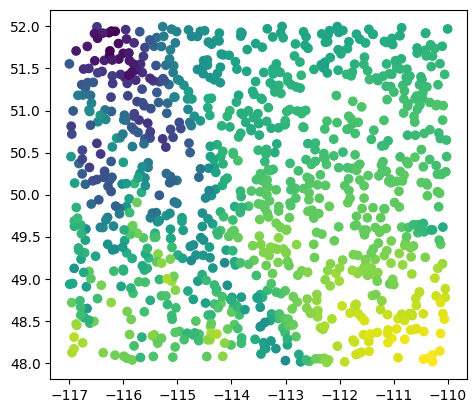

In [9]:
point_target ['values'] = ds_05['T2'][23,:].values
point_target_plot  = point_target.to_crs('epsg:4326')
point_target_plot.plot(column='values')

/Users/shg096/Desktop/EASYMORE/easymore-env/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: title={'center': 'time = 2000-10-01T23:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

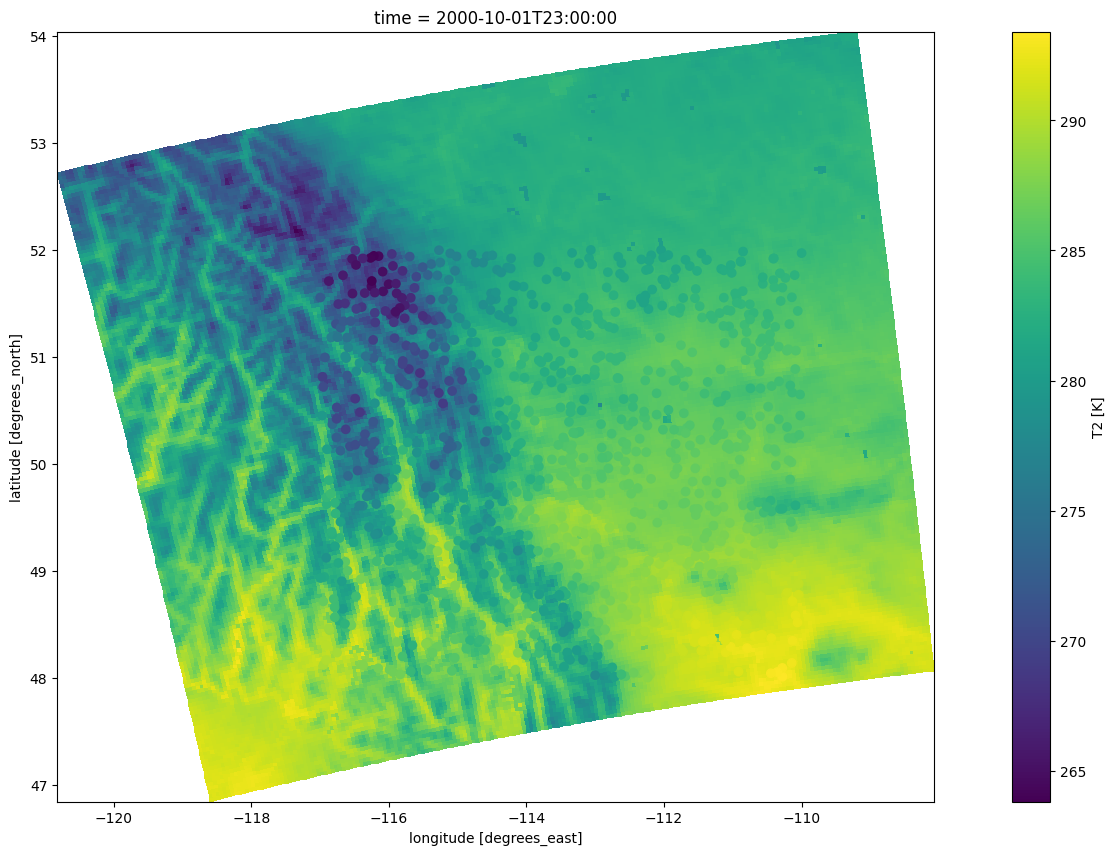

In [10]:
ds_source = xr.open_dataset('./data/Source_nc_WRF/WRF_merged_2000-10-01.nc')


fig, ax = fig, ax = plt.subplots(figsize=(20,10))
fig.set_facecolor("white")

ds_source['T2'].sel(time='2000-10-01 23:00:00', method='nearest').plot.pcolormesh(x='XLONG',
                                                                                  y='XLAT',
                                                                                  add_colorbar=True,
                                                                                  ax=ax,
                                                                                  cmap='viridis')

point_target_plot.plot(column='values',ax=ax)

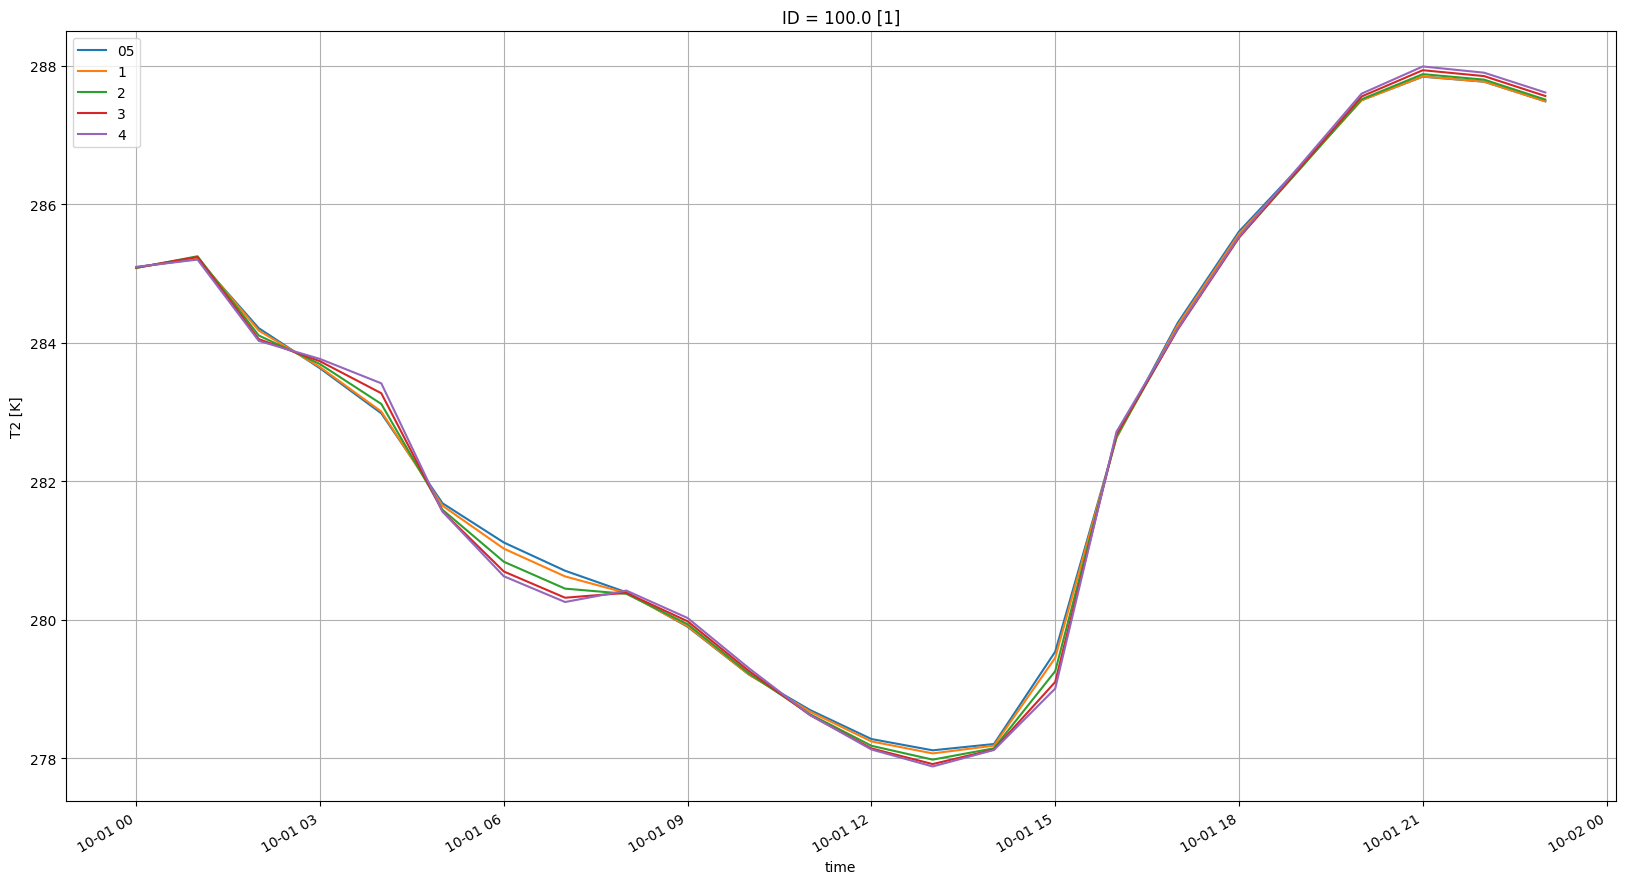

In [11]:
fig, ax = fig, ax = plt.subplots(figsize=(20,10))
fig.set_facecolor("white")

ds_05['T2'][:,99].plot(ax=ax, label = '05')
ds_1['T2'][:,99].plot(ax=ax, label = '1')
ds_2['T2'][:,99].plot(ax=ax, label = '2')
ds_3['T2'][:,99].plot(ax=ax, label = '3')
ds_4['T2'][:,99].plot(ax=ax, label = '4')

plt.legend()
plt.grid()